In [1]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
from astropy.table import Table
import corner

Before running this notebook, you'll need to extract the data points to fit to from Gammapy. This is done after generating your `lc_1d` object with the following lines of code:


    out = lc_1d.to_table(sed_type='dnde',format='lightcurve') 
    out.write('bllac_values.ecsv', overwrite=True)


You can change `sed_type` as necessary

# Read in Gammapy values

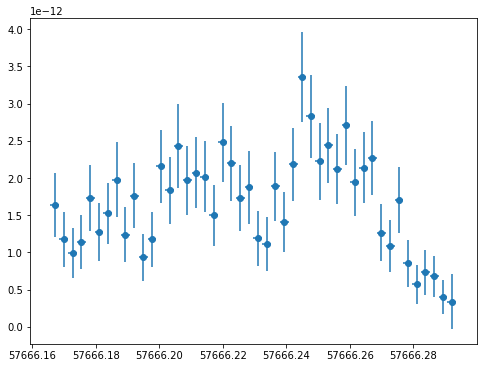

In [2]:
imp_tab=Table.read("bllac_values.ecsv")

time_min = imp_tab['time_min']
time_max = imp_tab['time_max']
flux = imp_tab['dnde']
flux_err = imp_tab['dnde_err']

flux_err = np.array(flux_err).flatten()
flux = np.array(flux).flatten()

time = np.array((time_min + time_max)/2).flatten()
time_bin = time - time_min

plt.figure(figsize=(8,6))
plt.errorbar(time, flux, yerr=flux_err.flatten(),xerr=time_bin,ls='',marker='o')
plt.ticklabel_format(useOffset=False,axis='x')

# Define the function you'd like to fit here

Plot an estimate to make sure the function is generally a good fit

In [3]:
def generalized_gaussian(t,amp,tref,trise,tdecay,kappa):
    out = np.zeros(len(t))
    mask = t < tref
    out[mask] = amp * np.exp((np.abs(t[mask]-tref)/trise))**kappa
    out[~mask] = amp * np.exp((np.abs(t[~mask]-tref)/tdecay))**kappa
    #print(out)
    return out

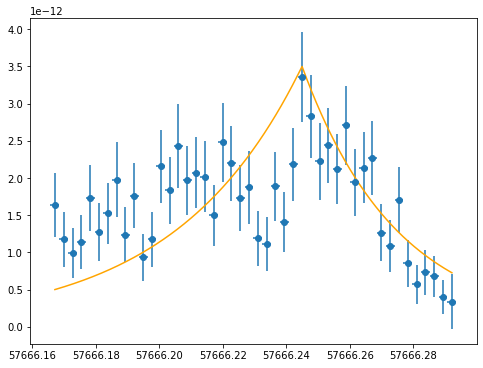

In [4]:
plt.figure(figsize=(8,6))
plt.errorbar(time, flux, yerr=flux_err.flatten(),xerr=time_bin,ls='',marker='o')
tplot=np.linspace(time[0],time[-1],1000)
plt.plot(tplot,generalized_gaussian(tplot,3.5e-12,57666.245,-2e-2,-1.5e-2,0.5),ls='-',color='orange')
#plt.yscale('log')
plt.ticklabel_format(useOffset=False,axis='x')

# MCMC steps using `emcee`

In [5]:
def lnprior(theta):
    amp,tref,trise,tdecay,kappa = theta
    if 0.0<amp<5e-12 and 57666.23 < tref < 57666.27 and -2 < trise < 0 and -2 < tdecay < 0 and 0.0 < kappa < 1.5:
        return 0.0
    return -np.inf

# Define log-likelihood function
def lnlike(params, t, y, y_err):
    amp,tref,trise,tdecay,kappa = params
    y_model = generalized_gaussian(t,amp,tref,trise,tdecay,kappa)
    sigma = np.std(y - y_model)
    return -0.5 * np.sum((y - y_model)**2 / y_err**2 + np.log(2 * np.pi * y_err**2))

def lnprob(theta, t, y, y_err):
    lp = lnprior(theta)
    if not np.all(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, t, y,y_err)

# Set up the sampler
ndim, nwalkers = 5, 100
a0 = 3.5e-12+1e-14 * np.random.randn(nwalkers)
tref0 = 57666.245+1e-2 * np.random.randn(nwalkers)
trise0 = -2e-2 +1e-4 * np.random.randn(nwalkers)
tdecay0 = -1.5e-2 + +1e-4 * np.random.randn(nwalkers)
kappa0 = 0.5 + 1e-2 * np.random.randn(nwalkers)
p0 = np.column_stack((a0,tref0,trise0,tdecay0,kappa0))

print(p0)

# MCMC sampling
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(time, flux, flux_err))
pos, prob, state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()
sampler.run_mcmc(pos, 10000, progress=True)
samples = sampler.get_chain()

  0%|                                                                                                     | 0/100 [00:00<?, ?it/s]/homes/wang/swong/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  8%|███████▍                                                                                     | 8/100 [00:00<00:01, 73.05it/s]

[[ 3.51429511e-12  5.76662284e+04 -2.00430979e-02 -1.49900195e-02
   4.98901574e-01]
 [ 3.50384841e-12  5.76662367e+04 -2.00388610e-02 -1.50154771e-02
   5.06410500e-01]
 [ 3.49893775e-12  5.76662320e+04 -1.99816832e-02 -1.49718776e-02
   5.13705635e-01]
 [ 3.50228636e-12  5.76662393e+04 -1.99041706e-02 -1.49282144e-02
   4.97318731e-01]
 [ 3.50772943e-12  5.76662545e+04 -1.97932160e-02 -1.51035019e-02
   5.02662033e-01]
 [ 3.51510683e-12  5.76662321e+04 -1.99251776e-02 -1.50518019e-02
   5.05515547e-01]
 [ 3.48260217e-12  5.76662489e+04 -2.01153924e-02 -1.49727115e-02
   4.98570011e-01]
 [ 3.49858980e-12  5.76662258e+04 -1.98801673e-02 -1.50403564e-02
   4.91698584e-01]
 [ 3.51535681e-12  5.76662329e+04 -1.98545726e-02 -1.48367764e-02
   5.16248569e-01]
 [ 3.49783425e-12  5.76662495e+04 -1.98730872e-02 -1.49049954e-02
   5.02745970e-01]
 [ 3.50161299e-12  5.76662531e+04 -2.00755973e-02 -1.50801503e-02
   5.19136704e-01]
 [ 3.50100074e-12  5.76662473e+04 -2.00284875e-02 -1.48578654e-02

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 181.01it/s]


# See if the fit converged

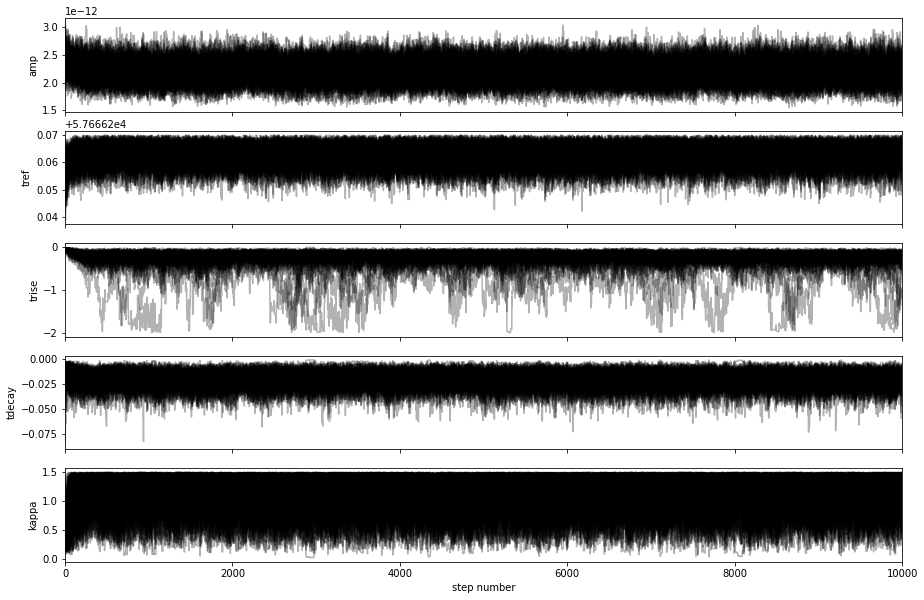

In [6]:
fig, axes = plt.subplots(5, figsize=(15, 10), sharex=True)

labels = ["amp","tref", "trise", "tdecay","kappa"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

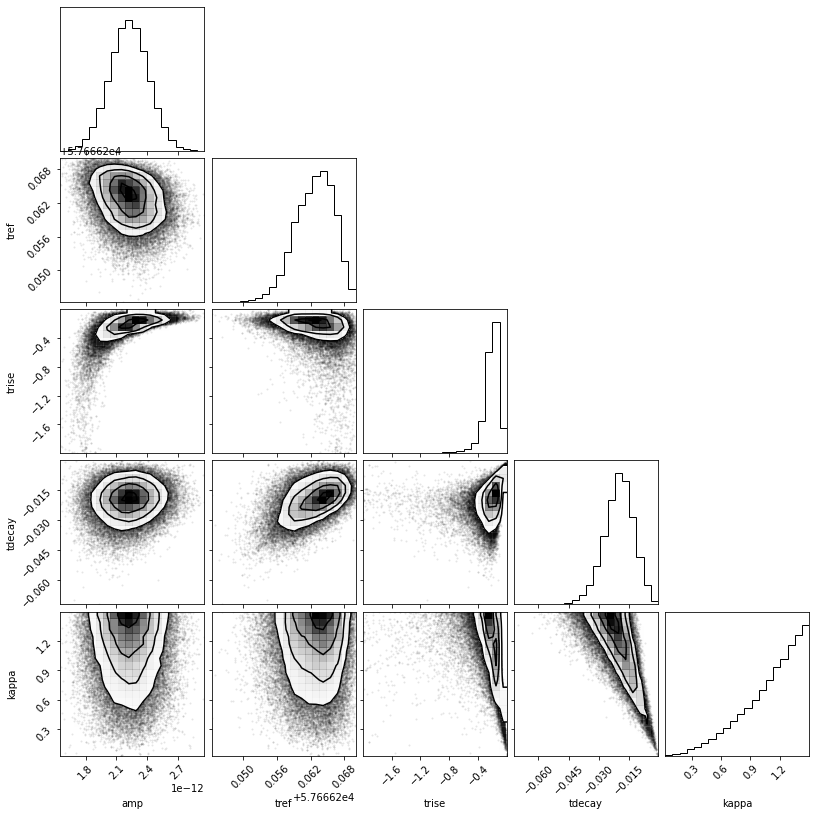

In [7]:
import corner
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels
    
)

# Best-fit parameters w/ errors

In [8]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3e}_{{-{1:.3e}}}^{{{2:.3e}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
params = np.array(())
for i in range(ndim):
    params = np.append(params,np.percentile(flat_samples[:, i], [50])[0])
    #print(np.percentile(flat_samples[:, i], [50])[0])

In [1]:
print(params)

NameError: name 'params' is not defined

# Plot original data w/ MCMC fits as errorbars

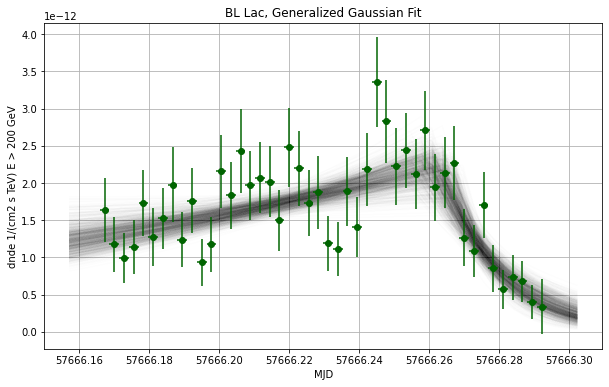

In [27]:
plt.figure(figsize=(10,6))
timeplot=np.linspace(time[0]-0.01,time[-1]+0.01)
for i in range(1000):
    plt.plot(timeplot, generalized_gaussian(timeplot,*flat_samples[-i]),alpha=0.006,color='k')
    #plt.axvline(flat_samples[-i][1],alpha=0.01,color='red')
plt.errorbar(time, flux, yerr=flux_err.flatten(),xerr=time_bin,ls='',marker='o',color='darkgreen')
plt.ylabel('dnde 1/(cm2 s TeV) E > 200 GeV')
plt.xlabel('MJD')
plt.ticklabel_format(axis='x',useOffset=False)
plt.title('BL Lac, Generalized Gaussian Fit')
plt.grid()
plt.show()

# Get $\chi^2$

In [32]:
def reduced_chi_squared(y, y_model,sigma, n_params):
    chi_squared = np.sum(((y - y_model) / sigma) ** 2)
    d_o_f = len(y) - n_params
    reduced_chi_squared = chi_squared / d_o_f
    return chi_squared, d_o_f

    return -0.5 * np.sum((y - y_model)**2 / y_err**2 + np.log(2 * np.pi * y_err**2))
chisq,dof = reduced_chi_squared(flux,generalized_gaussian(time,*params),flux_err,len(params))
print(chisq,dof)

41.038488170629414 41
